# Sampling Ablation Study Analysis

This notebook analyzes the sampling ablation study results to identify the best configurations for:
1. Exploration Temperature
2. Sampling Strategies
3. On-Policy vs Off-Policy
4. Preference Diversity
5. Batch Size Effects

**Inputs:**
- `results/ablations/sampling/all_results.csv`
- `configs/ablations/sampling_ablation.yaml`

**Outputs:**
- Summary reports for each experiment type
- Comparative visualizations
- Best configuration recommendations

In [21]:
import os 
from pathlib import Path

# Get the notebook's directory
notebook_dir = Path.cwd()
print(f"Current directory: {notebook_dir}")

# Find project root (look for src directory as marker)
project_root = notebook_dir
while not (project_root / 'src').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if (project_root / 'src').exists():
    os.chdir(project_root)
    print(f"✓ Changed to project root: {project_root}")
else:
    print("⚠ Warning: Could not find project root, using current directory")

# Verify the files exist
results_path = Path('results/ablations/sampling/all_results.csv')
config_path = Path('configs/ablations/sampling_ablation.yaml')

print(f"\nFile checks:")
print(f"  Results CSV exists: {results_path.exists()}")
print(f"  Config YAML exists: {config_path.exists()}")

Current directory: /Users/katherinedemers/Documents/GitHub/diversity-mogfn
✓ Changed to project root: /Users/katherinedemers/Documents/GitHub/diversity-mogfn

File checks:
  Results CSV exists: True
  Config YAML exists: True


In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Data and Configuration

In [23]:
# Load results
results_path = 'results/ablations/sampling/all_results.csv'
config_path = 'configs/ablations/sampling_ablation.yaml'

print(f"Loading results from: {results_path}")
df = pd.read_csv(results_path)
print(f"✓ Loaded {len(df)} experiments")
print(f"\nColumns: {list(df.columns)}")

# Load configuration
print(f"\nLoading config from: {config_path}")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"✓ Configuration loaded")

# Display first few rows
print("\nFirst 5 rows:")
df.head()

Loading results from: results/ablations/sampling/all_results.csv
✓ Loaded 205 experiments

Columns: ['hypervolume', 'r2_indicator', 'avg_pairwise_distance', 'spacing', 'spread', 'tds', 'mpd', 'mce', 'num_modes', 'pmd', 'pfs', 'pas', 'rbd', 'fci', 'qds', 'der', 'num_parameters', 'training_time', 'final_loss', 'seed', 'exp_name', 'hidden_dim', 'num_layers', 'conditioning']

Loading config from: configs/ablations/sampling_ablation.yaml
✓ Configuration loaded

First 5 rows:


,hypervolume,r2_indicator,avg_pairwise_distance,spacing,spread,tds,mpd,mce,num_modes,pmd,...,qds,der,num_parameters,training_time,final_loss,seed,exp_name,hidden_dim,num_layers,conditioning
0,1.043586,-0.252904,0.001955,5.960464e-08,1.462804,0.379798,4.521789,0.0,1,0.0,...,0.431862,0.043049,68103,2400.966037,0.010779,42,temp_low_seed42,128,4,concat
1,0.106980,-0.228602,0.004308,3.223147e-03,1.453089,0.382599,4.499810,0.0,1,0.0,...,0.045591,0.094512,68103,2409.706678,0.018505,123,temp_low_seed123,128,4,concat
2,0.518248,-0.170266,0.002223,0.000000e+00,1.407707,0.387340,4.553877,0.0,1,0.0,...,0.214866,0.048967,68103,2399.448203,0.014270,456,temp_low_seed456,128,4,concat
3,1.169203,-0.267603,0.003962,4.335602e-02,1.492769,0.401818,4.454347,0.0,1,0.0,...,0.484415,0.087273,68103,2399.992266,0.008476,789,temp_low_seed789,128,4,concat
4,0.786114,-0.217174,0.004801,1.780390e-02,1.591661,0.384700,4.564348,0.0,1,0.0,...,0.326383,0.105893,68103,2396.513162,0.006663,1011,temp_low_seed1011,128,4,concat


In [24]:
print("="*70)
print("AVERAGING RESULTS ACROSS SEEDS")
print("="*70)

# Define key metrics to analyze
key_metrics = [
    'hypervolume', 'num_modes', 'mpd', 'mce', 
    'pas', 'fci', 'qds', 'der', 'rbd', 'pmd'
]

# Filter to available metrics
available_metrics = [m for m in key_metrics if m in df.columns]

# Check if 'seed' column exists
if 'seed' in df.columns:
    print(f"\n✓ Found seed column with values: {sorted(df['seed'].unique())}")
    print(f"  Total experiments before averaging: {len(df)}")

    # Identify grouping columns (all except seed and metrics)
    # Typically these are: exp_name, and any configuration parameters
    group_cols = []

    # Check for exp_name (primary grouping)
    if 'exp_name' in df.columns:
        # Remove seed suffix from exp_name if it exists
        df['config_name'] = df['exp_name'].str.replace(r'_seed\d+', '', regex=True)
        group_cols.append('config_name')
        print(f"  Unique configurations: {df['config_name'].nunique()}")

    # Add other configuration columns if they exist
    config_columns = ['temperature', 'sampling_strategy', 'on_policy',
                     'preference_sampling', 'alpha', 'batch_size',
                     'capacity', 'conditioning', 'loss', 'hidden_dim', 'num_layers']

    for col in config_columns:
        if col in df.columns and col not in group_cols:
            group_cols.append(col)

    if not group_cols:
        print("  ⚠ Warning: Could not identify grouping columns, using exp_name")
        group_cols = ['exp_name']

    print(f"  Grouping by: {group_cols}")

    # Separate into metrics and non-metrics
    metric_cols = [col for col in df.columns if col in available_metrics or
                   col in ['training_time', 'num_parameters', 'final_loss']]

    print(f"  Metrics to average: {len(metric_cols)}")

    # Group and compute mean/std
    df_mean = df.groupby(group_cols)[metric_cols].mean().reset_index()
    df_std = df.groupby(group_cols)[metric_cols].std().reset_index()

    # Add std columns with _std suffix
    for col in metric_cols:
        if col in df_std.columns:
            df_mean[f'{col}_std'] = df_std[col]

    # Add count of seeds used
    df_mean['num_seeds'] = df.groupby(group_cols).size().values

    # Store original data
    df_original = df.copy()

    # Replace df with averaged data
    df = df_mean.copy()

    # If we created config_name, use it as exp_name
    if 'config_name' in df.columns:
        df['exp_name'] = df['config_name']
        df = df.drop('config_name', axis=1)

    print(f"\n✓ Averaging complete!")
    print(f"  Configurations after averaging: {len(df)}")
    print(f"  Seeds per configuration: {df['num_seeds'].iloc[0] if 'num_seeds' in df.columns else 'N/A'}")
    print(f"  Columns with std: {len([c for c in df.columns if '_std' in c])}")

    # Display sample of averaged data
    print("\n📊 Sample of averaged data:")
    display_cols = ['exp_name'] + available_metrics[:5]
    display_cols = [c for c in display_cols if c in df.columns]
    print(df[display_cols].head())

else:
    print("\n⚠ No 'seed' column found in data")
    print("  Proceeding with original data (assuming it's already averaged)")

print("\n" + "="*70)

AVERAGING RESULTS ACROSS SEEDS

✓ Found seed column with values: [42, 123, 456, 789, 1011]
  Total experiments before averaging: 205
  Unique configurations: 22
  Grouping by: ['config_name', 'conditioning', 'hidden_dim', 'num_layers']
  Metrics to average: 13

✓ Averaging complete!
  Configurations after averaging: 22
  Seeds per configuration: 10
  Columns with std: 13

📊 Sample of averaged data:
      exp_name  hypervolume  num_modes       mpd       mce       pas
0    batch_256     1.182131        2.0  1.445843  0.165990  0.107988
1     batch_32     1.177124        2.0  1.606312  0.179260  0.082424
2    batch_512     1.177214        2.2  1.335680  0.198917  0.108917
3     batch_64     1.177247        2.0  1.670882  0.195741  0.090861
4  categorical     1.179332        1.8  1.470780  0.181800  0.110786



In [25]:
# Create output directory
output_dir = Path('results/ablations/sampling/report')
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}")

# Define key metrics to analyze
key_metrics = [
    'mce', 'pas', 'qds', 'der'
]

# Filter to available metrics
available_metrics = [m for m in key_metrics if m in df.columns]
print(f"\nAvailable metrics for analysis: {available_metrics}")

✓ Output directory: results/ablations/sampling/report

Available metrics for analysis: ['mce', 'pas', 'qds', 'der']


## 2. Identify Experiment Types

Categorize experiments based on their configuration to identify which experiments test which hypotheses.

In [26]:
  # Identify experiment types based on varying parameters
def categorize_experiments(df):
      """
      Categorize experiments into different ablation types based on 
      what parameter is being varied.
      """
      categories = {}

      # Check which columns exist and vary
      param_columns = ['temperature', 'sampling_strategy', 'on_policy',
                       'preference_sampling', 'alpha', 'batch_size']

      available_params = [col for col in param_columns if col in df.columns]

      print("Available parameter columns:")
      for param in available_params:
          unique_vals = df[param].unique()
          print(f"  - {param}: {unique_vals} ({len(unique_vals)} values)")

      # Categorize based on exp_name patterns if parameters not directly available
      if 'exp_name' in df.columns:
          df['experiment_type'] = df['exp_name'].apply(lambda x: x.split('_')[0] if isinstance(x, str) else 'unknown')

          # More specific categorization - FIXED VERSION
          def get_category(name):
              """
              Categorize experiment based on name.
              
              Categories from sampling_ablation.yaml:
              1. temperature: temp_low, temp_medium, temp_high, temp_very_high
              2. sampling_strategy: greedy, categorical, top_k, top_p
              3. policy_type: on_policy_pure, off_policy_10, off_policy_25, off_policy_50
              4. preference_diversity: pref_uniform, pref_dirichlet_low, pref_dirichlet_medium, pref_dirichlet_high
              5. batch_size: batch_32, batch_64, batch_256, batch_512
              6. combined: diverse_sampling, quality_sampling
              """
              if pd.isna(name):
                  return 'unknown'

              name_str = str(name).lower()

              # Temperature experiments
              if name_str.startswith('temp_'):
                  return 'temperature'

              # Sampling strategy experiments
              elif name_str in ['greedy', 'categorical', 'top_k', 'top_p']:
                  return 'sampling_strategy'

              # Policy type experiments (on-policy vs off-policy)
              elif name_str.startswith('on_policy') or name_str.startswith('off_policy'):
                  return 'policy_type'

              # Preference diversity experiments
              elif name_str.startswith('pref_'):
                  return 'preference_diversity'

              # Batch size experiments
              elif name_str.startswith('batch_'):
                  return 'batch_size'

              # Combined experiments
              elif name_str in ['diverse_sampling', 'quality_sampling']:
                  return 'combined'

              else:
                  return 'other'

          df['experiment_category'] = df['exp_name'].apply(get_category)

          print("\nExperiment categories identified:")
          print(df['experiment_category'].value_counts())

      return df

df = categorize_experiments(df)

Available parameter columns:

Experiment categories identified:
experiment_category
batch_size              4
sampling_strategy       4
policy_type             4
preference_diversity    4
temperature             4
combined                2
Name: count, dtype: int64


## 3. Experiment 1: Exploration Temperature

Analyze how temperature affects exploration-exploitation trade-off.

In [27]:
# Filter temperature experiments
temp_df = df[df['experiment_category'] == 'temperature'].copy()

if len(temp_df) > 0:
    print(f"Temperature experiments: {len(temp_df)}")
    print(f"Unique experiment names: {temp_df['exp_name'].unique()}")
    
    # Summary statistics
    temp_summary = temp_df.groupby('exp_name')[available_metrics].agg(['mean', 'std', 'count'])
    temp_summary.to_csv(output_dir / 'temperature_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'temperature_summary.csv'}")
    
    # Display summary
    display(temp_summary.round(4))
    
    # Find best configuration for each metric
    print("\n📊 Best Temperature Configuration per Metric:")
    for metric in available_metrics[:5]:  # Top 5 metrics
        best_config = temp_summary[(metric, 'mean')].idxmax()
        best_value = temp_summary.loc[best_config, (metric, 'mean')]
        print(f"  {metric.upper()}: {best_config} ({best_value:.4f})")
else:
    print("⚠ No temperature experiments found in data")

Temperature experiments: 4
Unique experiment names: ['temp_high' 'temp_low' 'temp_medium' 'temp_very_high']

✓ Saved: results/ablations/sampling/report/temperature_summary.csv


mce               pas               qds                der  \
                  mean std count    mean std count    mean std count     mean   
exp_name                                                                        
temp_high       0.3701 NaN     1  0.4847 NaN     1  0.6389 NaN     1  13.6896   
temp_low        0.0000 NaN     1  0.0034 NaN     1  0.3006 NaN     1   0.0759   
temp_medium     0.1818 NaN     1  0.1108 NaN     1  0.5187 NaN     1   2.5120   
temp_very_high  0.2588 NaN     1  0.2510 NaN     1  0.5638 NaN     1  12.3012   

                          
               std count  
exp_name                  
temp_high      NaN     1  
temp_low       NaN     1  
temp_medium    NaN     1  
temp_very_high NaN     1


📊 Best Temperature Configuration per Metric:
  MCE: temp_high (0.3701)
  PAS: temp_high (0.4847)
  QDS: temp_high (0.6389)
  DER: temp_high (13.6896)


✓ Saved: results/ablations/sampling/report/temperature_comparison.png


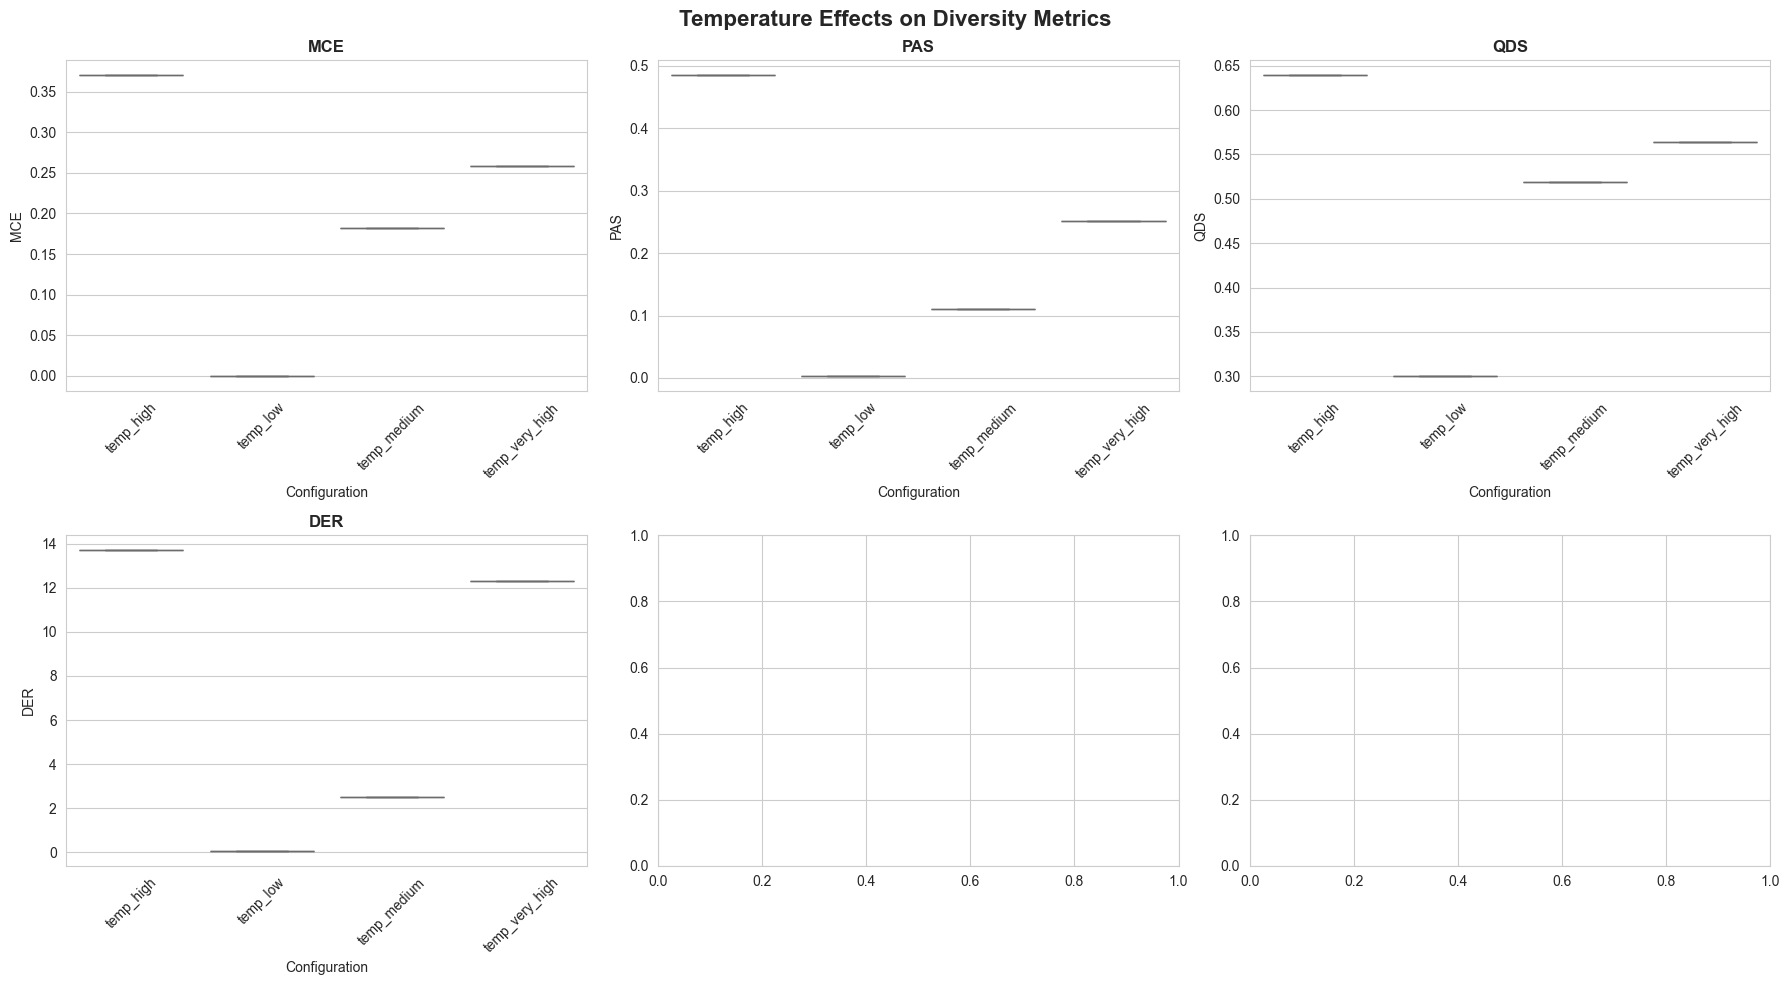

In [28]:
# Visualize temperature effects
if len(temp_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Temperature Effects on Diversity Metrics', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(available_metrics[:6]):
        ax = axes[idx // 3, idx % 3]
        
        # Box plot
        temp_df_plot = temp_df[['exp_name', metric]].dropna()
        if len(temp_df_plot) > 0:
            sns.boxplot(data=temp_df_plot, x='exp_name', y=metric, ax=ax)
            ax.set_title(f'{metric.upper()}', fontweight='bold')
            ax.set_xlabel('Configuration')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'temperature_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'temperature_comparison.png'}")
    plt.show()

## 4. Experiment 2: Sampling Strategies

Compare different sampling strategies (greedy, stochastic, etc.).

In [29]:
# Filter sampling strategy experiments
strategy_df = df[df['experiment_category'] == 'sampling_strategy'].copy()

if len(strategy_df) > 0:
    print(f"Sampling strategy experiments: {len(strategy_df)}")
    print(f"Unique experiment names: {strategy_df['exp_name'].unique()}")
    
    # Summary statistics
    strategy_summary = strategy_df.groupby('exp_name')[available_metrics].agg(['mean', 'std', 'count'])
    strategy_summary.to_csv(output_dir / 'sampling_strategy_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'sampling_strategy_summary.csv'}")
    
    display(strategy_summary.round(4))
    
    # Best configuration
    print("\n📊 Best Sampling Strategy per Metric:")
    for metric in available_metrics[:5]:
        best_config = strategy_summary[(metric, 'mean')].idxmax()
        best_value = strategy_summary.loc[best_config, (metric, 'mean')]
        print(f"  {metric.upper()}: {best_config} ({best_value:.4f})")
else:
    print("⚠ No sampling strategy experiments found in data")

Sampling strategy experiments: 4
Unique experiment names: ['categorical' 'greedy' 'top_k' 'top_p']

✓ Saved: results/ablations/sampling/report/sampling_strategy_summary.csv


mce               pas               qds               der      \
               mean std count    mean std count    mean std count    mean std   
exp_name                                                                        
categorical  0.1818 NaN     1  0.1108 NaN     1  0.5187 NaN     1  2.5143 NaN   
greedy       0.0000 NaN     1  0.0000 NaN     1  0.0442 NaN     1  0.0000 NaN   
top_k        0.2024 NaN     1  0.0951 NaN     1  0.5137 NaN     1  2.1381 NaN   
top_p        0.0000 NaN     1  0.0011 NaN     1  0.0446 NaN     1  0.0231 NaN   

                   
            count  
exp_name           
categorical     1  
greedy          1  
top_k           1  
top_p           1


📊 Best Sampling Strategy per Metric:
  MCE: top_k (0.2024)
  PAS: categorical (0.1108)
  QDS: categorical (0.5187)
  DER: categorical (2.5143)


✓ Saved: results/ablations/sampling/report/sampling_strategy_comparison.png


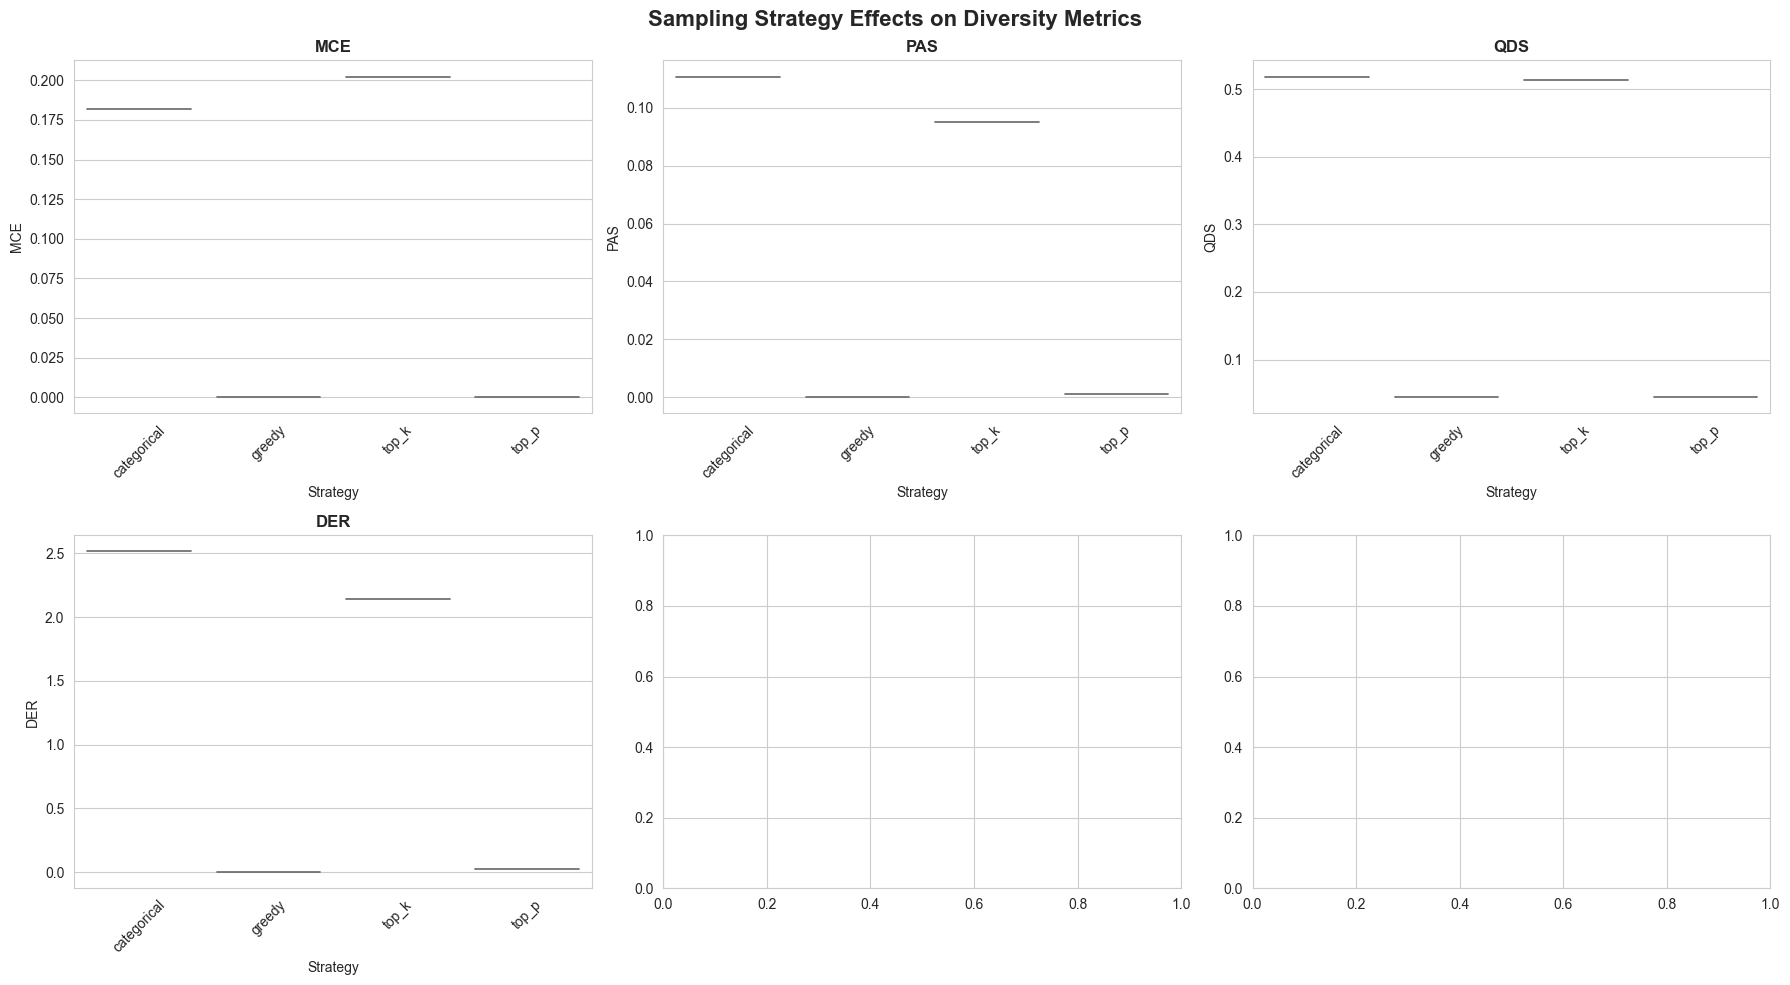

In [30]:
# Visualize sampling strategy effects
if len(strategy_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Sampling Strategy Effects on Diversity Metrics', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(available_metrics[:6]):
        ax = axes[idx // 3, idx % 3]
        
        strategy_df_plot = strategy_df[['exp_name', metric]].dropna()
        if len(strategy_df_plot) > 0:
            sns.violinplot(data=strategy_df_plot, x='exp_name', y=metric, ax=ax)
            ax.set_title(f'{metric.upper()}', fontweight='bold')
            ax.set_xlabel('Strategy')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'sampling_strategy_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'sampling_strategy_comparison.png'}")
    plt.show()

## 5. Experiment 3: On-Policy vs Off-Policy

Compare on-policy and off-policy learning approaches.

In [31]:
# Filter policy type experiments
policy_df = df[df['experiment_category'] == 'policy_type'].copy()

if len(policy_df) > 0:
    print(f"Policy type experiments: {len(policy_df)}")
    print(f"Unique experiment names: {policy_df['exp_name'].unique()}")
    
    # Summary statistics
    policy_summary = policy_df.groupby('exp_name')[available_metrics].agg(['mean', 'std', 'count'])
    policy_summary.to_csv(output_dir / 'policy_type_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'policy_type_summary.csv'}")
    
    display(policy_summary.round(4))
    
    # Best configuration
    print("\n📊 Best Policy Type per Metric:")
    for metric in available_metrics[:5]:
        best_config = policy_summary[(metric, 'mean')].idxmax()
        best_value = policy_summary.loc[best_config, (metric, 'mean')]
        print(f"  {metric.upper()}: {best_config} ({best_value:.4f})")
    
    # Statistical comparison
    print("\n📈 Performance Comparison (On-Policy vs Off-Policy):")
    on_policy = policy_df[policy_df['exp_name'].str.contains('on', case=False, na=False)]
    off_policy = policy_df[policy_df['exp_name'].str.contains('off', case=False, na=False)]
    
    if len(on_policy) > 0 and len(off_policy) > 0:
        for metric in available_metrics[:5]:
            on_mean = on_policy[metric].mean()
            off_mean = off_policy[metric].mean()
            diff = ((on_mean - off_mean) / off_mean * 100) if off_mean != 0 else 0
            winner = "On-Policy" if on_mean > off_mean else "Off-Policy"
            print(f"  {metric.upper()}: {winner} wins by {abs(diff):.2f}%")
else:
    print("⚠ No policy type experiments found in data")

Policy type experiments: 4
Unique experiment names: ['off_policy_10' 'off_policy_25' 'off_policy_50' 'on_policy_pure']

✓ Saved: results/ablations/sampling/report/policy_type_summary.csv


mce               pas               qds                der  \
                  mean std count    mean std count    mean std count     mean   
exp_name                                                                        
off_policy_10   0.4534 NaN     1  0.4734 NaN     1  0.6353 NaN     1  13.0396   
off_policy_25   0.4226 NaN     1  0.4388 NaN     1  0.6242 NaN     1  15.8204   
off_policy_50   0.2181 NaN     1  0.2151 NaN     1  0.5523 NaN     1  11.3284   
on_policy_pure  0.1818 NaN     1  0.1108 NaN     1  0.5187 NaN     1   2.5183   

                          
               std count  
exp_name                  
off_policy_10  NaN     1  
off_policy_25  NaN     1  
off_policy_50  NaN     1  
on_policy_pure NaN     1


📊 Best Policy Type per Metric:
  MCE: off_policy_10 (0.4534)
  PAS: off_policy_10 (0.4734)
  QDS: off_policy_10 (0.6353)
  DER: off_policy_25 (15.8204)

📈 Performance Comparison (On-Policy vs Off-Policy):
  MCE: Off-Policy wins by 50.15%
  PAS: Off-Policy wins by 70.52%
  QDS: Off-Policy wins by 14.10%
  DER: Off-Policy wins by 81.20%


✓ Saved: results/ablations/sampling/report/policy_type_comparison.png


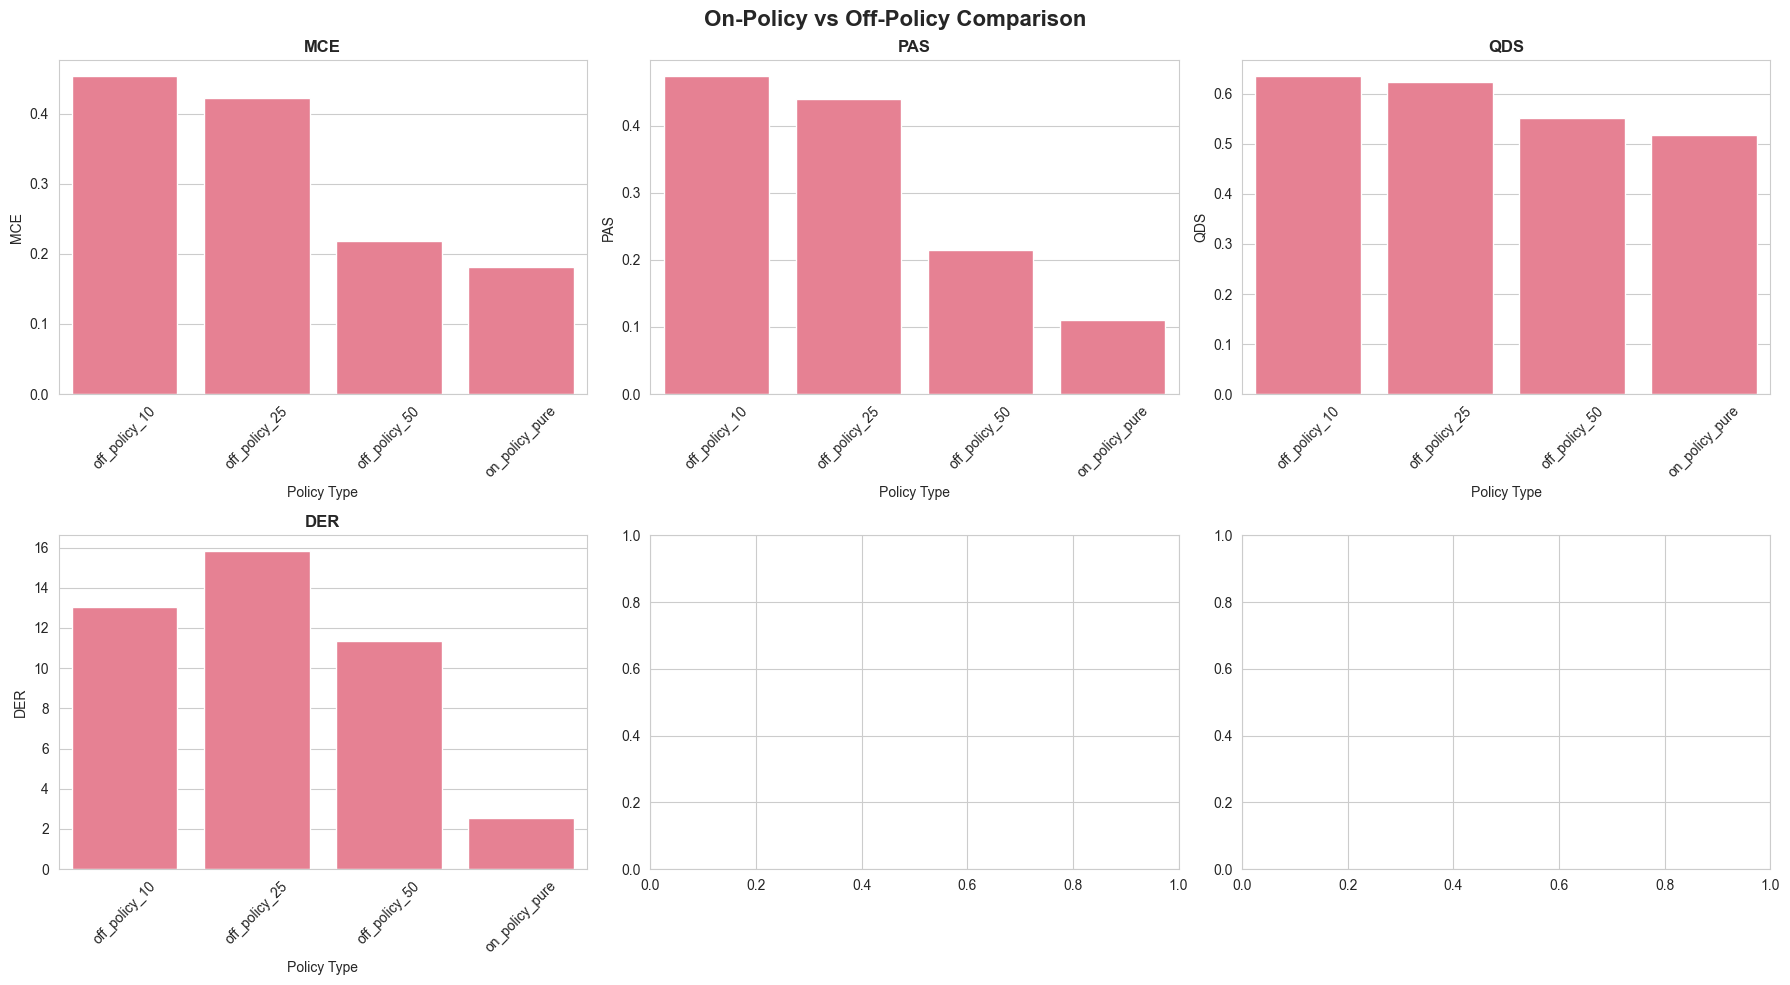

In [32]:
# Visualize policy type effects
if len(policy_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('On-Policy vs Off-Policy Comparison', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(available_metrics[:6]):
        ax = axes[idx // 3, idx % 3]
        
        policy_df_plot = policy_df[['exp_name', metric]].dropna()
        if len(policy_df_plot) > 0:
            sns.barplot(data=policy_df_plot, x='exp_name', y=metric, ax=ax, ci='sd')
            ax.set_title(f'{metric.upper()}', fontweight='bold')
            ax.set_xlabel('Policy Type')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'policy_type_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'policy_type_comparison.png'}")
    plt.show()

## 6. Experiment 4: Preference Diversity

Analyze the impact of different preference sampling distributions (Dirichlet vs Uniform).

In [33]:
# Filter preference diversity experiments
pref_df = df[df['experiment_category'] == 'preference_diversity'].copy()

if len(pref_df) > 0:
    print(f"Preference diversity experiments: {len(pref_df)}")
    print(f"Unique experiment names: {pref_df['exp_name'].unique()}")
    
    # Summary statistics
    pref_summary = pref_df.groupby('exp_name')[available_metrics].agg(['mean', 'std', 'count'])
    pref_summary.to_csv(output_dir / 'preference_diversity_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'preference_diversity_summary.csv'}")
    
    display(pref_summary.round(4))
    
    # Best configuration
    print("\n📊 Best Preference Sampling per Metric:")
    for metric in available_metrics[:5]:
        best_config = pref_summary[(metric, 'mean')].idxmax()
        best_value = pref_summary.loc[best_config, (metric, 'mean')]
        print(f"  {metric.upper()}: {best_config} ({best_value:.4f})")
    
    # Analyze alpha parameter effect (if available)
    if 'alpha' in pref_df.columns:
        print("\n📈 Alpha Parameter Analysis:")
        for alpha_val in sorted(pref_df['alpha'].unique()):
            alpha_data = pref_df[pref_df['alpha'] == alpha_val]
            print(f"\n  Alpha = {alpha_val}:")
            for metric in available_metrics[:3]:
                mean_val = alpha_data[metric].mean()
                print(f"    {metric.upper()}: {mean_val:.4f}")
else:
    print("⚠ No preference diversity experiments found in data")

Preference diversity experiments: 4
Unique experiment names: ['pref_dirichlet_high' 'pref_dirichlet_low' 'pref_dirichlet_medium'
 'pref_uniform']

✓ Saved: results/ablations/sampling/report/preference_diversity_summary.csv


mce               pas               qds            \
                         mean std count    mean std count    mean std count   
exp_name                                                                      
pref_dirichlet_high    0.2001 NaN     1  0.0945 NaN     1  0.5135 NaN     1   
pref_dirichlet_low     0.2134 NaN     1  0.1122 NaN     1  0.5192 NaN     1   
pref_dirichlet_medium  0.1818 NaN     1  0.1108 NaN     1  0.5187 NaN     1   
pref_uniform           0.1517 NaN     1  0.1055 NaN     1  0.5170 NaN     1   

                          der            
                         mean std count  
exp_name                                 
pref_dirichlet_high    2.1460 NaN     1  
pref_dirichlet_low     2.5569 NaN     1  
pref_dirichlet_medium  2.5177 NaN     1  
pref_uniform           2.4005 NaN     1


📊 Best Preference Sampling per Metric:
  MCE: pref_dirichlet_low (0.2134)
  PAS: pref_dirichlet_low (0.1122)
  QDS: pref_dirichlet_low (0.5192)
  DER: pref_dirichlet_low (2.5569)


✓ Saved: results/ablations/sampling/report/preference_diversity_comparison.png


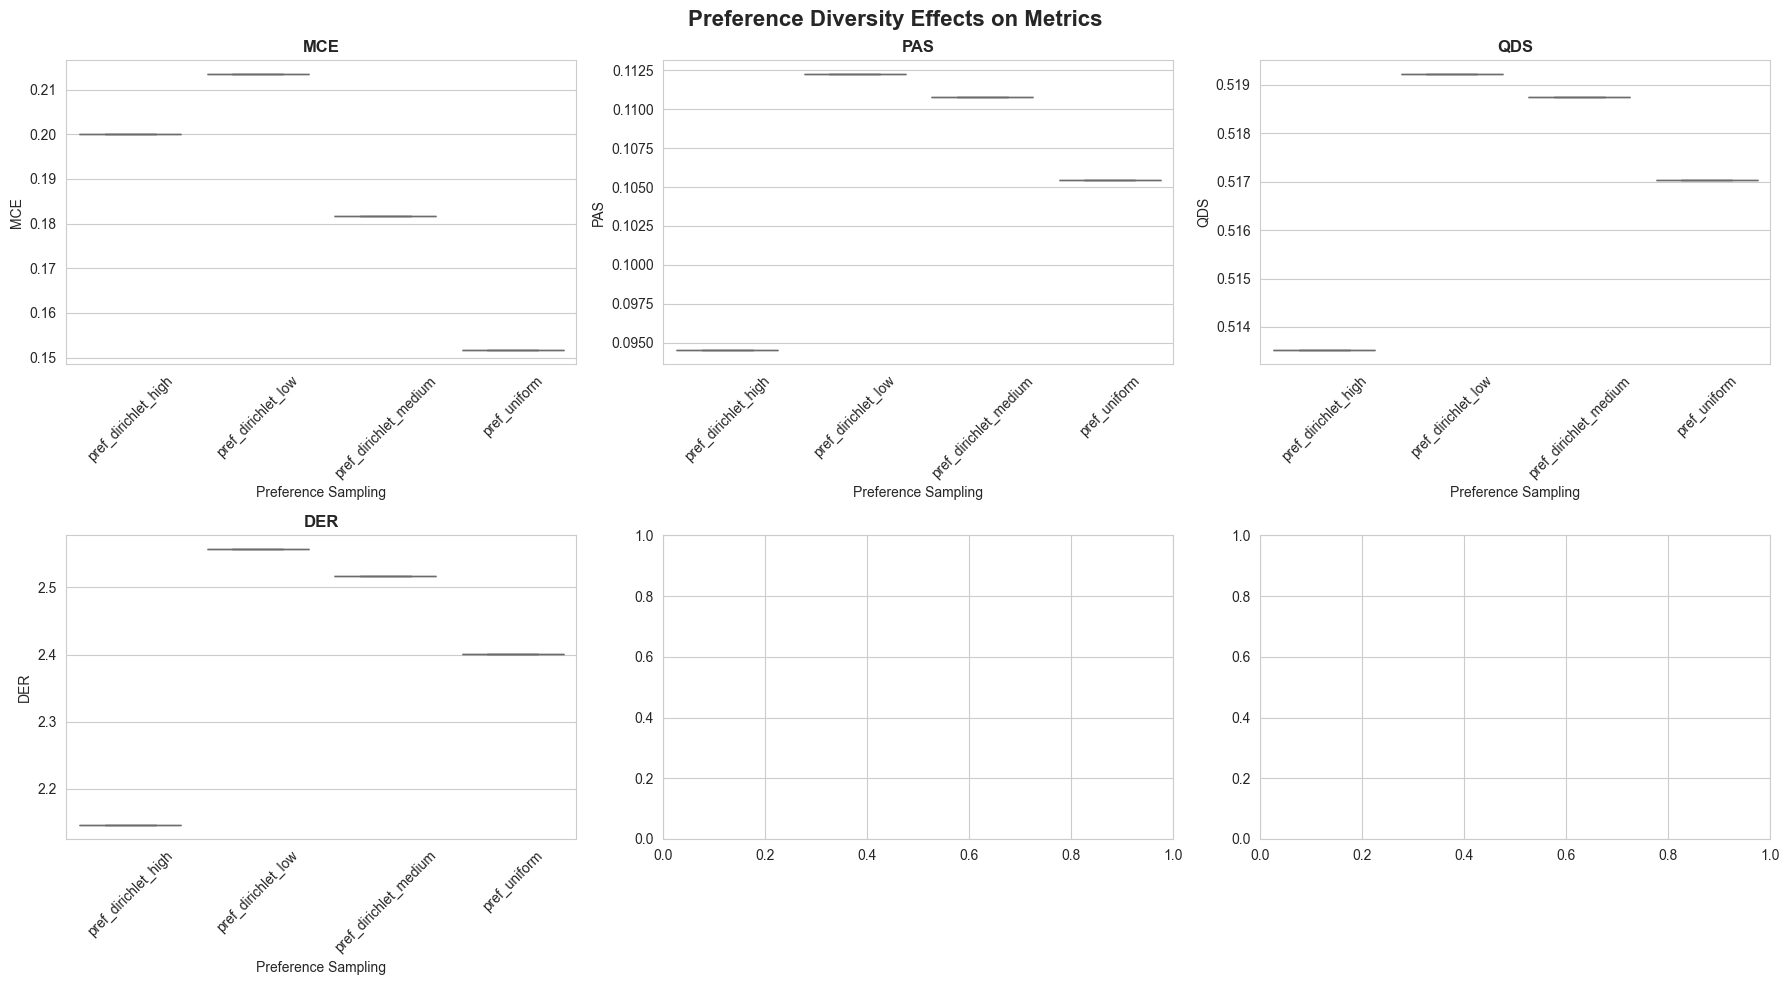

In [34]:
# Visualize preference diversity effects
if len(pref_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Preference Diversity Effects on Metrics', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(available_metrics[:6]):
        ax = axes[idx // 3, idx % 3]
        
        pref_df_plot = pref_df[['exp_name', metric]].dropna()
        if len(pref_df_plot) > 0:
            sns.boxplot(data=pref_df_plot, x='exp_name', y=metric, ax=ax)
            ax.set_title(f'{metric.upper()}', fontweight='bold')
            ax.set_xlabel('Preference Sampling')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'preference_diversity_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'preference_diversity_comparison.png'}")
    plt.show()

## 7. Experiment 5: Batch Size Effects

Analyze how batch size affects training dynamics and diversity metrics.

In [35]:
# Filter batch size experiments
batch_df = df[df['experiment_category'] == 'batch_size'].copy()

if len(batch_df) > 0:
    print(f"Batch size experiments: {len(batch_df)}")
    print(f"Unique experiment names: {batch_df['exp_name'].unique()}")
    
    # Summary statistics
    batch_summary = batch_df.groupby('exp_name')[available_metrics].agg(['mean', 'std', 'count'])
    batch_summary.to_csv(output_dir / 'batch_size_summary.csv')
    print(f"\n✓ Saved: {output_dir / 'batch_size_summary.csv'}")
    
    display(batch_summary.round(4))
    
    # Best configuration
    print("\n📊 Best Batch Size per Metric:")
    for metric in available_metrics[:5]:
        best_config = batch_summary[(metric, 'mean')].idxmax()
        best_value = batch_summary.loc[best_config, (metric, 'mean')]
        print(f"  {metric.upper()}: {best_config} ({best_value:.4f})")
    
    # Training efficiency analysis
    if 'training_time' in batch_df.columns:
        print("\n⏱️ Training Efficiency:")
        efficiency_df = batch_df.groupby('exp_name')[['training_time'] + available_metrics[:3]].mean()
        display(efficiency_df.round(4))
else:
    print("⚠ No batch size experiments found in data")

Batch size experiments: 4
Unique experiment names: ['batch_256' 'batch_32' 'batch_512' 'batch_64']

✓ Saved: results/ablations/sampling/report/batch_size_summary.csv


mce               pas               qds               der      \
             mean std count    mean std count    mean std count    mean std   
exp_name                                                                      
batch_256  0.1660 NaN     1  0.1080 NaN     1  0.5179 NaN     1  1.2084 NaN   
batch_32   0.1793 NaN     1  0.0824 NaN     1  0.5096 NaN     1  7.6848 NaN   
batch_512  0.1989 NaN     1  0.1089 NaN     1  0.5181 NaN     1  0.5982 NaN   
batch_64   0.1957 NaN     1  0.0909 NaN     1  0.5123 NaN     1  4.1687 NaN   

                 
          count  
exp_name         
batch_256     1  
batch_32      1  
batch_512     1  
batch_64      1


📊 Best Batch Size per Metric:
  MCE: batch_512 (0.1989)
  PAS: batch_512 (0.1089)
  QDS: batch_512 (0.5181)
  DER: batch_32 (7.6848)

⏱️ Training Efficiency:


,training_time,mce,pas,qds
exp_name,,,,
batch_256,4725.4977,0.1660,0.1080,0.5179
batch_32,566.9710,0.1793,0.0824,0.5096
batch_512,9632.4548,0.1989,0.1089,0.5181
batch_64,1152.2857,0.1957,0.0909,0.5123


✓ Saved: results/ablations/sampling/report/batch_size_comparison.png


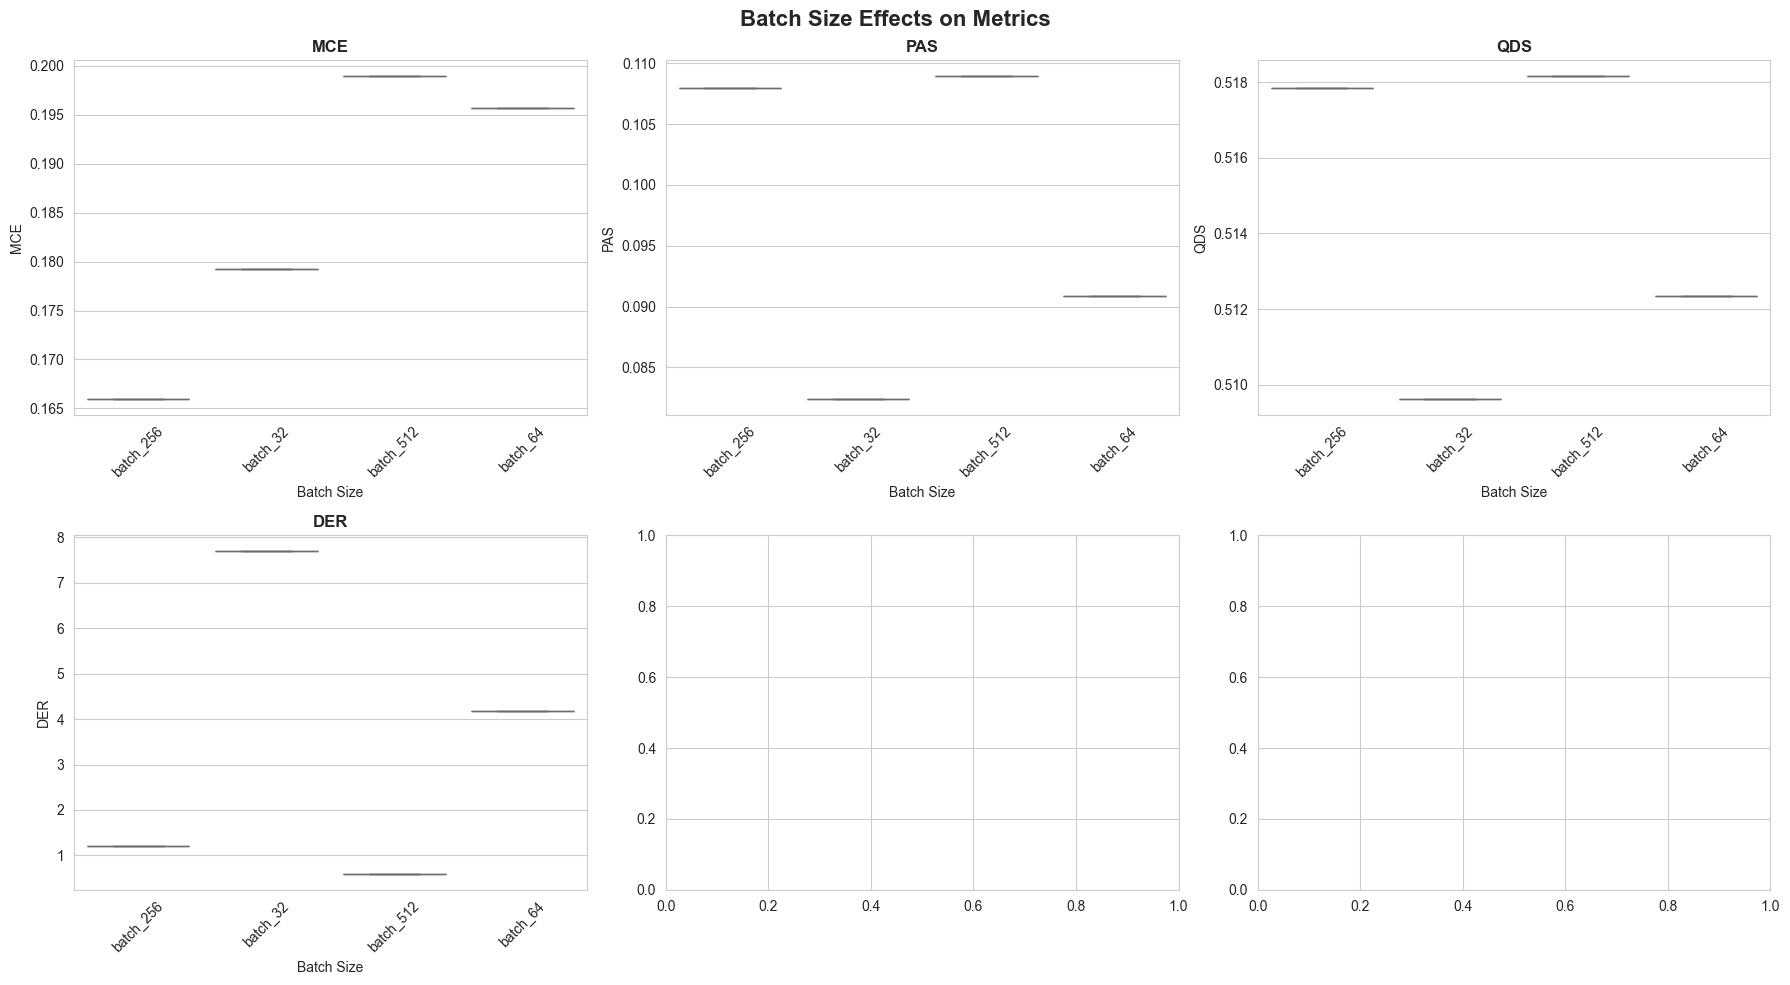

In [36]:
# Visualize batch size effects
if len(batch_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Batch Size Effects on Metrics', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(available_metrics[:6]):
        ax = axes[idx // 3, idx % 3]
        
        batch_df_plot = batch_df[['exp_name', metric]].dropna()
        if len(batch_df_plot) > 0:
            sns.boxplot(data=batch_df_plot, x='exp_name', y=metric, ax=ax)
            ax.set_title(f'{metric.upper()}', fontweight='bold')
            ax.set_xlabel('Batch Size')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'batch_size_comparison.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir / 'batch_size_comparison.png'}")
    plt.show()

## 8. Overall Best Configuration Analysis

Rank all configurations across all experiment types to identify the overall best settings.

In [37]:
# Compute overall rankings
print("🏆 Overall Best Configurations Across All Experiments")
print("="*70)

overall_summary = df.groupby('exp_name')[available_metrics].mean()

# Rank by each metric
rankings = {}
for metric in available_metrics:
    rankings[metric] = overall_summary[metric].sort_values(ascending=False)
    print(f"\n{metric.upper()} - Top 5 Configurations:")
    for i, (config, value) in enumerate(rankings[metric].head(5).items(), 1):
        print(f"  {i}. {config}: {value:.4f}")

# Save overall rankings
overall_summary.to_csv(output_dir / 'overall_configuration_rankings.csv')
print(f"\n✓ Saved: {output_dir / 'overall_configuration_rankings.csv'}")

🏆 Overall Best Configurations Across All Experiments

MCE - Top 5 Configurations:
  1. diverse_sampling: 0.4806
  2. off_policy_10: 0.4534
  3. off_policy_25: 0.4226
  4. quality_sampling: 0.3733
  5. temp_high: 0.3701

PAS - Top 5 Configurations:
  1. diverse_sampling: 0.5021
  2. temp_high: 0.4847
  3. off_policy_10: 0.4734
  4. off_policy_25: 0.4388
  5. quality_sampling: 0.3315

QDS - Top 5 Configurations:
  1. diverse_sampling: 0.6445
  2. temp_high: 0.6389
  3. off_policy_10: 0.6353
  4. off_policy_25: 0.6242
  5. quality_sampling: 0.5897

DER - Top 5 Configurations:
  1. off_policy_25: 15.8204
  2. diverse_sampling: 14.2119
  3. temp_high: 13.6896
  4. off_policy_10: 13.0396
  5. temp_very_high: 12.3012

✓ Saved: results/ablations/sampling/report/overall_configuration_rankings.csv



📊 Top 5 Configurations by Average Rank:
  1. diverse_sampling (Avg Rank: 1.25)
  2. off_policy_10 (Avg Rank: 3.00)
  3. off_policy_25 (Avg Rank: 3.00)
  4. temp_high (Avg Rank: 3.00)
  5. quality_sampling (Avg Rank: 5.25)

✓ Saved: results/ablations/sampling/report/top_configurations_radar.png


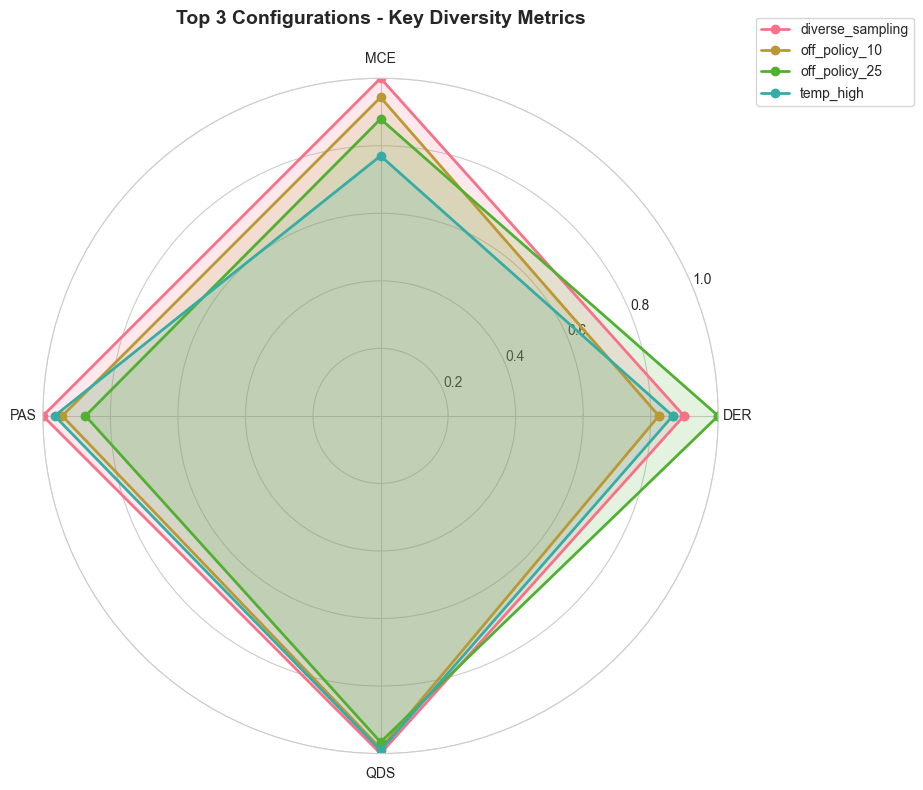

In [41]:
# Create radar chart for top configurations
from math import pi

# Select top 5 configurations by average rank
rank_scores = {}
for config in overall_summary.index:
           ranks = []
           for metric in available_metrics:
               rank = rankings[metric].index.get_loc(config) + 1
               ranks.append(rank)
           rank_scores[config] = np.mean(ranks)

top_configs = sorted(rank_scores.items(), key=lambda x: x[1])[:5]
print("\n📊 Top 5 Configurations by Average Rank:")
for i, (config, avg_rank) in enumerate(top_configs, 1):
           print(f"  {i}. {config} (Avg Rank: {avg_rank:.2f})")

       # Create radar chart with key diversity metrics only
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='polar')

       # Define key diversity metrics to display
radar_metrics = ['der', 'mce', 'pas', 'qds']

       # Normalize metrics to 0-1 for comparison
normalized_data = {}
for metric in radar_metrics:
           min_val = overall_summary[metric].min()
           max_val = overall_summary[metric].max()
           normalized_data[metric] = (overall_summary[metric] - min_val) / (max_val - min_val + 1e-10)

       # Plot top 3 configurations
angles = [n / float(len(radar_metrics)) * 2 * pi for n in range(len(radar_metrics))]
angles += angles[:1]

for config, _ in top_configs[:4]:
           values = [normalized_data[metric][config] for metric in radar_metrics]
           values += values[:1]
           ax.plot(angles, values, 'o-', linewidth=2, label=config)
           ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.upper() for m in radar_metrics])
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Top 3 Configurations - Key Diversity Metrics', size=14, fontweight='bold', pad=20)
ax.grid(True)

plt.tight_layout()
plt.savefig(output_dir / 'top_configurations_radar.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Saved: {output_dir / 'top_configurations_radar.png'}")
plt.show()

## 9. Comprehensive Summary Report

Generate final recommendations based on all analyses.

In [39]:
# Generate comprehensive report
report = []
report.append("="*70)
report.append("SAMPLING ABLATION STUDY - COMPREHENSIVE REPORT")
report.append("="*70)
report.append("")

# Summary by experiment type
experiment_types = [
    ('temperature', 'Exploration Temperature', temp_df),
    ('sampling_strategy', 'Sampling Strategies', strategy_df),
    ('policy_type', 'On-Policy vs Off-Policy', policy_df),
    ('preference_diversity', 'Preference Diversity', pref_df),
    ('batch_size', 'Batch Size Effects', batch_df)
]

for exp_type, title, exp_df in experiment_types:
    if len(exp_df) > 0:
        report.append(f"\n## {title}")
        report.append("-" * 70)
        
        # Best configuration for each key metric
        summary = exp_df.groupby('exp_name')[available_metrics[:5]].mean()
        
        for metric in available_metrics[:5]:
            best_config = summary[metric].idxmax()
            best_value = summary[metric].max()
            report.append(f"  Best {metric.upper()}: {best_config} ({best_value:.4f})")

report.append("\n")
report.append("="*70)
report.append("OVERALL RECOMMENDATIONS")
report.append("="*70)
report.append("")
report.append("Top 5 Configurations by Average Rank:")
for i, (config, avg_rank) in enumerate(top_configs, 1):
    report.append(f"  {i}. {config} (Average Rank: {avg_rank:.2f})")

report.append("\n")
report.append("Key Insights:")
report.append("  - Review the generated CSVs for detailed statistics")
report.append("  - Compare PNG visualizations for metric-specific trends")
report.append("  - Consider trade-offs between different metrics based on your goals")
report.append("")
report.append("="*70)

# Print report
report_text = "\n".join(report)
print(report_text)

# Save report
with open(output_dir / 'comprehensive_report.txt', 'w') as f:
    f.write(report_text)

print(f"\n✓ Saved: {output_dir / 'comprehensive_report.txt'}")

SAMPLING ABLATION STUDY - COMPREHENSIVE REPORT


## Exploration Temperature
----------------------------------------------------------------------
  Best MCE: temp_high (0.3701)
  Best PAS: temp_high (0.4847)
  Best QDS: temp_high (0.6389)
  Best DER: temp_high (13.6896)

## Sampling Strategies
----------------------------------------------------------------------
  Best MCE: top_k (0.2024)
  Best PAS: categorical (0.1108)
  Best QDS: categorical (0.5187)
  Best DER: categorical (2.5143)

## On-Policy vs Off-Policy
----------------------------------------------------------------------
  Best MCE: off_policy_10 (0.4534)
  Best PAS: off_policy_10 (0.4734)
  Best QDS: off_policy_10 (0.6353)
  Best DER: off_policy_25 (15.8204)

## Preference Diversity
----------------------------------------------------------------------
  Best MCE: pref_dirichlet_low (0.2134)
  Best PAS: pref_dirichlet_low (0.1122)
  Best QDS: pref_dirichlet_low (0.5192)
  Best DER: pref_dirichlet_low (2.5569)

## Batch S

In [40]:
# List all generated files
print("\n📁 Generated Files:")
print("="*70)
generated_files = sorted(output_dir.glob('*'))
for file in generated_files:
    print(f"  ✓ {file.name}")

print(f"\nTotal: {len(generated_files)} files generated in {output_dir}")


📁 Generated Files:
  ✓ batch_size_comparison.png
  ✓ batch_size_summary.csv
  ✓ comprehensive_report.txt
  ✓ grouped_bar_batch_size.png
  ✓ grouped_bar_combined.png
  ✓ grouped_bar_off-policy.png
  ✓ grouped_bar_preference.png
  ✓ grouped_bar_strategy.png
  ✓ grouped_bar_temperature.png
  ✓ grouped_bar_top_performers.png
  ✓ overall_configuration_rankings.csv
  ✓ policy_type_comparison.png
  ✓ policy_type_summary.csv
  ✓ preference_diversity_comparison.png
  ✓ preference_diversity_summary.csv
  ✓ sampling_strategy_comparison.png
  ✓ sampling_strategy_summary.csv
  ✓ temperature_comparison.png
  ✓ temperature_summary.csv
  ✓ top_configurations_radar.png

Total: 20 files generated in results/ablations/sampling/report


## 10. Next Steps

Based on the analysis:

1. **Review the summary CSVs** for detailed statistics on each experiment type
2. **Examine the visualizations** to understand metric-specific trends
3. **Compare top configurations** using the radar chart
4. **Select the best configuration** based on your specific optimization goals
5. **Run validation experiments** with the recommended settings

**Key Files:**
- `temperature_summary.csv` - Temperature ablation results
- `sampling_strategy_summary.csv` - Strategy comparison
- `policy_type_summary.csv` - On/off-policy comparison
- `preference_diversity_summary.csv` - Preference sampling analysis
- `batch_size_summary.csv` - Batch size effects
- `overall_configuration_rankings.csv` - Complete rankings
- `comprehensive_report.txt` - Text summary with recommendations